In [2]:
import pandas as pd

In [3]:
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [4]:
import os
import sys
module_path = os.path.abspath(os.path.join(os.pardir, os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import pandas as pd
import nltk
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.tokenize import regexp_tokenize, word_tokenize, RegexpTokenizer
from nltk import pos_tag
from nltk.corpus import wordnet
import matplotlib.pyplot as plt
import string
import re
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer,\
HashingVectorizer

from sklearn.metrics import mean_squared_error, r2_score, confusion_matrix, \
plot_confusion_matrix,  precision_score, recall_score, accuracy_score, f1_score, \
log_loss, roc_curve, roc_auc_score, classification_report, plot_roc_curve

In [5]:
df = pd.read_csv('../Data/judge-1377884607_tweet_product_company.csv', encoding='Latin-1')
df

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion
...,...,...,...
9088,Ipad everywhere. #SXSW {link},iPad,Positive emotion
9089,"Wave, buzz... RT @mention We interrupt your re...",NaN,No emotion toward brand or product
9090,"Google's Zeiger, a physician never reported po...",NaN,No emotion toward brand or product
9091,Some Verizon iPhone customers complained their...,NaN,No emotion toward brand or product


In [6]:
# check for nulls on tweet_text
df['tweet_text'].isna().sum()

1

In [7]:
df['is_there_an_emotion_directed_at_a_brand_or_product'].value_counts()

No emotion toward brand or product    5389
Positive emotion                      2978
Negative emotion                       570
I can't tell                           156
Name: is_there_an_emotion_directed_at_a_brand_or_product, dtype: int64

In [8]:
df['emotion_in_tweet_is_directed_at'].value_counts()

iPad                               946
Apple                              661
iPad or iPhone App                 470
Google                             430
iPhone                             297
Other Google product or service    293
Android App                         81
Android                             78
Other Apple product or service      35
Name: emotion_in_tweet_is_directed_at, dtype: int64

In [9]:
# replace iPhone to Apple
df['emotion_in_tweet_is_directed_at'].replace(to_replace='iPhone', value='Apple', inplace=True)

In [10]:
# replace ipad or iphone app to apple 
df['emotion_in_tweet_is_directed_at'].replace(to_replace='iPad or iPhone App', value='Apple', inplace=True)

In [11]:
# replace ipad or iphone app to apple 
df['emotion_in_tweet_is_directed_at'].replace(to_replace='iPad', value='Apple', inplace=True)

In [12]:
# replace ther Apple pr to apple 
df['emotion_in_tweet_is_directed_at'].replace(to_replace='Other Apple product or service', value='Apple', inplace=True)

In [13]:
df['emotion_in_tweet_is_directed_at'].value_counts()

Apple                              2409
Google                              430
Other Google product or service     293
Android App                          81
Android                              78
Name: emotion_in_tweet_is_directed_at, dtype: int64

In [14]:
# replace Android App to Google
df['emotion_in_tweet_is_directed_at'].replace(to_replace='Android App', value='Google', inplace=True)

In [15]:
# replace ther Google product or service App to Google
df['emotion_in_tweet_is_directed_at'].replace(to_replace='Other Google product or service', value='Google', inplace=True)

In [16]:
# replace "Android" to Google
df['emotion_in_tweet_is_directed_at'].replace(to_replace='Android', value='Google', inplace=True)

In [17]:
df['emotion_in_tweet_is_directed_at'].value_counts()

Apple     2409
Google     882
Name: emotion_in_tweet_is_directed_at, dtype: int64

In [18]:
X = df['tweet_text']
y = df['is_there_an_emotion_directed_at_a_brand_or_product']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [19]:
sample_document = df['tweet_text'][1]
sample_document

"@jessedee Know about @fludapp ? Awesome iPad/iPhone app that you'll likely appreciate for its design. Also, they're giving free Ts at #SXSW"

In [20]:
pattern = "([a-zA-Z]+(?:'[a-z]+)?)"
tokenizer = RegexpTokenizer(pattern)
sample_doc = tokenizer.tokenize(sample_document)
sample_doc = [token.lower() for token in sample_doc]
sw = stopwords.words('english')
sample_doc = [token for token in sample_doc if token not in sw]


In [21]:
sample_doc

['jessedee',
 'know',
 'fludapp',
 'awesome',
 'ipad',
 'iphone',
 'app',
 'likely',
 'appreciate',
 'design',
 'also',
 "they're",
 'giving',
 'free',
 'ts',
 'sxsw']

In [22]:
# dropping the null value
df.dropna(subset=['tweet_text'], how='all', inplace=True)

In [23]:
# checking it has been dropped
df['tweet_text'].isna().sum()

0

In [24]:
# clean the text
# create a function
def cleanTxt(text):
    text = re.sub(r'@[A-Za-z0-9]+', '', text)  #remove @ mentions
    text = re.sub(r'#', '', text)   #remove the '# symbol'
    text = re.sub(r'RT[\s]+', '', text)   #remove RT retweet
    text = re.sub(r'https?:\/\/\S+', '', text)  #remove the hyper link
    
    return text

#cleaning the text
df['tweet_text'] = df['tweet_text'].apply(cleanTxt)

In [25]:
# We removed numbers and punctuation
def remove_punct(text):
    text  = "".join([char for char in text if char not in string.punctuation])
    text = re.sub('[0-9]+', '', text)
    return text

df['tweet_text'] = df['tweet_text'].apply(lambda x: remove_punct(x))

In [26]:
# @Terry: replaced Nan from second column to Apple or Google adding it to a fourth column
def Find_Apple_or_Google(text):
    category =''
    pattern = "([a-zA-Z]+(?:'[a-z]+)?)"
    tokenizer = RegexpTokenizer(pattern)
    sample_doc = tokenizer.tokenize(text)
    sample_doc = [token.lower() for token in sample_doc]
    sw = stopwords.words('english')
    sample_doc = [token for token in sample_doc if token not in sw]
    ap = ['apple', 'ipad', 'iphone']
    go = ['google','android']
    if any((match := item) in sample_doc for item in ap):
        return 'Apple'
    elif any((match := item) in sample_doc for item in go):
        return 'Google'
    else:
        return 'NAN'

In [27]:
ap = ['apple', 'ipad', 'iphone']
go = ['google','android']

In [28]:
if any((match := item) in sample_doc for item in ap):
   
    print(match)


ipad


In [29]:
if any((match := item) in sample_doc for item in ap):
   
    print(match)


ipad


In [30]:
df['Product_Category'] = df['tweet_text'].apply(lambda x: Find_Apple_or_Google(x))

In [31]:
df['Product_Category'].value_counts() 

Apple     5263
Google    2481
NAN       1348
Name: Product_Category, dtype: int64

In [32]:
def tokenization(text):
    pattern = "([a-zA-Z]+(?:'[a-z]+)?)"
    tokenizer = RegexpTokenizer(pattern)
    sample_doc = tokenizer.tokenize(text)
    return sample_doc

In [33]:
df['Tweet_tokenized'] = df['tweet_text'].apply(lambda x: tokenization(x.lower()))

In [34]:
# stopwords english 
stopword = nltk.corpus.stopwords.words('english')

In [35]:
# adding sxsw to the stop words  
new_stopwords = ["sxsw"]
stopword.extend(new_stopwords)

In [36]:
def remove_stopwords(text):
    text = [word for word in text if word not in stopword]
    return text

In [37]:
df['Tweet_nonstop'] = df['Tweet_tokenized'].apply(lambda x: remove_stopwords(x))

In [38]:
ps = nltk.PorterStemmer()

def stemming(text):
    text = [ps.stem(word) for word in text]
    return text


In [39]:
df['Tweet_stemmed'] = df['Tweet_nonstop'].apply(lambda x: stemming(x))

In [40]:
df['tweet_text'][0]

' I have a G iPhone After  hrs tweeting at RISEAustin it was dead  I need to upgrade Plugin stations at SXSW'

In [41]:
df['Tweet_tokenized'][0]

['i',
 'have',
 'a',
 'g',
 'iphone',
 'after',
 'hrs',
 'tweeting',
 'at',
 'riseaustin',
 'it',
 'was',
 'dead',
 'i',
 'need',
 'to',
 'upgrade',
 'plugin',
 'stations',
 'at',
 'sxsw']

In [42]:
df['Tweet_stemmed'][0]

['g',
 'iphon',
 'hr',
 'tweet',
 'riseaustin',
 'dead',
 'need',
 'upgrad',
 'plugin',
 'station']

In [43]:
# this concludes the cleaning 
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
def word_lemmatizer(text):
    lem_text = [WordNetLemmatizer().lemmatize(i) for i in text]
    return lem_text
df['tweet_lemma'] = df['Tweet_nonstop'].apply(lambda x: word_lemmatizer(x))
df.tail(4)

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Terry\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product,Product_Category,Tweet_tokenized,Tweet_nonstop,Tweet_stemmed,tweet_lemma
9089,Wave buzz We interrupt your regularly schedule...,NaN,No emotion toward brand or product,Google,"[wave, buzz, we, interrupt, your, regularly, s...","[wave, buzz, interrupt, regularly, scheduled, ...","[wave, buzz, interrupt, regularli, schedul, ge...","[wave, buzz, interrupt, regularly, scheduled, ..."
9090,Googles Zeiger a physician never reported pote...,NaN,No emotion toward brand or product,NAN,"[googles, zeiger, a, physician, never, reporte...","[googles, zeiger, physician, never, reported, ...","[googl, zeiger, physician, never, report, pote...","[google, zeiger, physician, never, reported, p..."
9091,Some Verizon iPhone customers complained their...,NaN,No emotion toward brand or product,Apple,"[some, verizon, iphone, customers, complained,...","[verizon, iphone, customers, complained, time,...","[verizon, iphon, custom, complain, time, fell,...","[verizon, iphone, customer, complained, time, ..."
9092,Ï¡ÏàüÊÎÒ£Áââ£âÛâGoogle ...,NaN,No emotion toward brand or product,Google,"[google, tests, checkin, offers, at, sxsw, link]","[google, tests, checkin, offers, link]","[googl, test, checkin, offer, link]","[google, test, checkin, offer, link]"


In [44]:
df['is_there_an_emotion_directed_at_a_brand_or_product'].value_counts()

No emotion toward brand or product    5388
Positive emotion                      2978
Negative emotion                       570
I can't tell                           156
Name: is_there_an_emotion_directed_at_a_brand_or_product, dtype: int64

In [45]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
def visualize_top_10(freq_dist, title):
    # Extract data for plotting
    top_10 = list(zip(*freq_dist.most_common(10)))
    tokens = top_10[0]
    counts = top_10[1]
    # Set up plot and plot data
    fig, ax = plt.subplots()
    ax.bar(tokens, counts)
    # Customize plot appearance
    ax.set_title(title)
    ax.set_ylabel("Count")
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax.tick_params(axis="x", rotation=90)

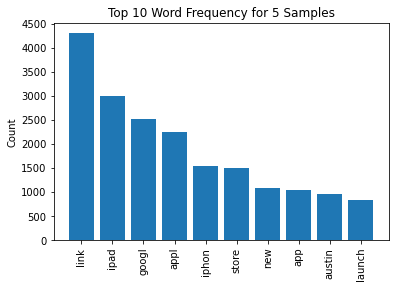

In [46]:
sample_freq_dist = FreqDist(df['Tweet_stemmed'].explode())
visualize_top_10(sample_freq_dist, "Top 10 Word Frequency for 5 Samples")

In [47]:
vec = CountVectorizer(token_pattern=r"([a-zA-Z]+(?:'[a-z]+)?)", stop_words=sw)

In [48]:
# making 'tweet_lemma' into sentce instead of a list
df['lemma_sentence'] =df['tweet_lemma'].apply(lambda x: " ".join(x))


In [49]:
# selecting only the positive and negative values from the dataset 
df1 = df[(df.is_there_an_emotion_directed_at_a_brand_or_product == 'Positive emotion') | (df.is_there_an_emotion_directed_at_a_brand_or_product == 'Negative emotion')]


In [50]:
# sanity check
df1['is_there_an_emotion_directed_at_a_brand_or_product'].value_counts()

Positive emotion    2978
Negative emotion     570
Name: is_there_an_emotion_directed_at_a_brand_or_product, dtype: int64

In [51]:
df1['emotion_in_tweet_is_directed_at'].value_counts()

Apple     2337
Google     854
Name: emotion_in_tweet_is_directed_at, dtype: int64

In [52]:
df1['emotion_in_tweet_is_directed_at']

0        Apple
1        Apple
2        Apple
3        Apple
4       Google
         ...  
9077     Apple
9079     Apple
9080    Google
9085     Apple
9088     Apple
Name: emotion_in_tweet_is_directed_at, Length: 3548, dtype: object

In [53]:
df1[df1['emotion_in_tweet_is_directed_at'].isna()]

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product,Product_Category,Tweet_tokenized,Tweet_nonstop,Tweet_stemmed,tweet_lemma,lemma_sentence
46,HandHeld Û÷HoboÛª Drafthouse launches Û÷Hob...,NaN,Positive emotion,Apple,"[handheld, hobo, drafthouse, launches, hobo, w...","[handheld, hobo, drafthouse, launches, hobo, s...","[handheld, hobo, drafthous, launch, hobo, shot...","[handheld, hobo, drafthouse, launch, hobo, sho...",handheld hobo drafthouse launch hobo shotgun i...
64,Again Line at the Apple store is insane sxsw,NaN,Negative emotion,Apple,"[again, line, at, the, apple, store, is, insan...","[line, apple, store, insane]","[line, appl, store, insan]","[line, apple, store, insane]",line apple store insane
68,Boooo Flipboard is developing an iPhone versio...,NaN,Negative emotion,Apple,"[boooo, flipboard, is, developing, an, iphone,...","[boooo, flipboard, developing, iphone, version...","[boooo, flipboard, develop, iphon, version, an...","[boooo, flipboard, developing, iphone, version...",boooo flipboard developing iphone version andr...
103,Know that quotdatavizquot translates to quotsa...,NaN,Negative emotion,Apple,"[know, that, quotdatavizquot, translates, to, ...","[know, quotdatavizquot, translates, quotsatani...","[know, quotdatavizquot, translat, quotsatanicq...","[know, quotdatavizquot, translates, quotsatani...",know quotdatavizquot translates quotsatanicquo...
112,Spark for android is up for a teamandroid awar...,NaN,Positive emotion,Google,"[spark, for, android, is, up, for, a, teamandr...","[spark, android, teamandroid, award, read, link]","[spark, android, teamandroid, award, read, link]","[spark, android, teamandroid, award, read, link]",spark android teamandroid award read link
...,...,...,...,...,...,...,...,...,...
9011,apparently the line to get an iPad at the sxsw...,NaN,Positive emotion,Apple,"[apparently, the, line, to, get, an, ipad, at,...","[apparently, line, get, ipad, store, grew, blo...","[appar, line, get, ipad, store, grew, block, b...","[apparently, line, get, ipad, store, grew, blo...",apparently line get ipad store grew block bloc...
9043,Hey is anyone doing sxsw signing up for the gr...,NaN,Negative emotion,Apple,"[hey, is, anyone, doing, sxsw, signing, up, fo...","[hey, anyone, signing, group, texting, app, gr...","[hey, anyon, sign, group, text, app, groupm, g...","[hey, anyone, signing, group, texting, app, gr...",hey anyone signing group texting app groupme g...
9049,you can buy my used iPad and Ill pick one up ...,NaN,Positive emotion,Apple,"[you, can, buy, my, used, ipad, and, ill, pick...","[buy, used, ipad, ill, pick, one, tomorrow]","[buy, use, ipad, ill, pick, one, tomorrow]","[buy, used, ipad, ill, pick, one, tomorrow]",buy used ipad ill pick one tomorrow
9052,You could buy a new iPad tmrw at the Apple p...,NaN,Positive emotion,Apple,"[you, could, buy, a, new, ipad, tmrw, at, the,...","[could, buy, new, ipad, tmrw, apple, popup, st...","[could, buy, new, ipad, tmrw, appl, popup, sto...","[could, buy, new, ipad, tmrw, apple, popup, st...",could buy new ipad tmrw apple popup store link


In [54]:
df1['Product_Category'].value_counts()

Apple     2401
Google     865
NAN        282
Name: Product_Category, dtype: int64

# Train Test Split

In [55]:
# splitting the training data into train and valid sets
from sklearn.model_selection import train_test_split
X = df1['lemma_sentence']
y = df1['is_there_an_emotion_directed_at_a_brand_or_product']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)

In [190]:
# Creating a count Vectorizer with default parameters 
from sklearn.feature_extraction.text import CountVectorizer
vec = CountVectorizer()
X_vec = vec.fit_transform(X_train)

In [57]:
# Creating a basline model with naive bayes
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score
# Instantiate a MultinomialNB classifier
baseline_model = MultinomialNB()
# Evaluate the classifier on X_train_vectorized and y_train
baseline_cv = cross_val_score(baseline_model, X_vec , y_train)
baseline_cv

array([0.84052533, 0.83646617, 0.84398496, 0.82706767, 0.83082707])

In [58]:
baseline_cv.mean()

0.8357742385983722

# Try more model classifier

Here, we are trying to make default model classifier to see if the cross val score will have a great improvement compared with our baseline model. But it seems like there's no improvement with both random forest and decision tree model

In [60]:
# Instantiating a default Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
model0 = RandomForestClassifier(random_state=42)
model0.fit(X_vec, y_train)
y_pred0 = model0.predict(X_t_vec)
print("Training Accuracy :", model0.score(X_vec, y_train))
print("Testing Accuracy :", model0.score(X_t_vec, y_test))


Training Accuracy : 0.8729800826756858
Testing Accuracy : 0.8376550169109357


In [61]:
# Evaluate the classifier
ran0_cv = cross_val_score(model0, X_vec, y_train, cv=5)
ran0_cv.mean()

0.8335214208128201

In [62]:
# Instantiating a default Decision Tree Classifier
from sklearn.tree import DecisionTreeClassifier
model0_de = DecisionTreeClassifier()
model0_de.fit(X_vec, y_train)
y_pred0_de = model0_de.predict(X_t_vec)
print("Training Accuracy :", model0_de.score(X_vec, y_train))
print("Testing Accuracy :", model0_de.score(X_t_vec, y_test))


Training Accuracy : 0.8729800826756858
Testing Accuracy : 0.8297632468996617


In [63]:
# Evaluate the classifier
dt1_cv = cross_val_score(model0_de, X_vec, y_train, cv=5)
dt1_cv.mean()

0.8173637658875142

# Grid search

Since the defalut random forest and decision tree model didn't have agood result. We thought about this problems and decided to use grid search on Count vecterizer to see if we can get a better result.

After we did the grid search for Count vecterizer, we found the best parameter as {ngram_range = (1,2), min_df= 2}. By applying these parameter, the result improved with cross val score as 0.870

In [64]:
# Instantiating Count vectorizer with updated parameters
vec1 = CountVectorizer(ngram_range = (1,2), min_df= 2)
X1_vec = vec1.fit_transform(X_train)


In [65]:
# Evaluate the classifier
ran1_cv = cross_val_score(model0, X1_vec, y_train, cv=5)
ran1_cv.mean()

0.8707295913329289

Now it's time to do some grid search for random forest. Here we trying more then ten grid searches and the grid search below was our best one. This was a very long grid search and took 663 min to run it through. The cross val score increased from 0.807 to 0.877

In [238]:
# Grid search for random forest parameters
grid4 = {'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}

gs4 = GridSearchCV(estimator=RandomForestClassifier(),
                 param_grid=grid4,
                 cv=5,
                 verbose=3,
                 n_jobs=-2)

In [239]:
gs4.fit(X1_vec,y_train)

Fitting 5 folds for each of 3960 candidates, totalling 19800 fits


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  18 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-2)]: Done 114 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-2)]: Done 274 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-2)]: Done 498 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-2)]: Done 786 tasks      | elapsed:  9.4min
[Parallel(n_jobs=-2)]: Done 1138 tasks      | elapsed: 14.8min
[Parallel(n_jobs=-2)]: Done 1554 tasks      | elapsed: 22.8min
[Parallel(n_jobs=-2)]: Done 2034 tasks      | elapsed: 33.6min
[Parallel(n_jobs=-2)]: Done 2578 tasks      | elapsed: 44.6min
[Parallel(n_jobs=-2)]: Done 3186 tasks      | elapsed: 59.0min
[Parallel(n_jobs=-2)]: Done 3858 tasks      | elapsed: 76.8min
[Parallel(n_jobs=-2)]: Done 4594 tasks      | elapsed: 97.4min
[Parallel(n_jobs=-2)]: Done 5394 tasks      | elapsed: 120.0min
[Parallel(n_jobs=-2)]: Done 6258 tasks      | elapsed: 147.1min
[Parallel(n_jobs=-2)]: Done 7186 tasks      |

GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-2,
             param_grid={'bootstrap': [True, False],
                         'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100,
                                       None],
                         'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400,
                                          1600, 1800, 2000]},
             verbose=3)

In [240]:
gs4.best_params_

{'bootstrap': False,
 'max_depth': None,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 5,
 'n_estimators': 200}

In [241]:
gs4.best_score_

0.8774915713298256

# Final model

For our final model, the best parameters for both vecterizer abd random forest model both showed below

Best parameter for Count vecterizer   :
{ngram_range : (1,2),
  min_df : 2}

Best parameter for random forest : 
{'bootstrap': False, 
 'max_depth': None, 
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 5,
 'n_estimators': 200}

In [243]:
# Instantiating Random forest Classifier with best parameters
rf_final = RandomForestClassifier(bootstrap = False, max_depth = None, max_features = 'sqrt', min_samples_leaf= 1, min_samples_split= 5, n_estimators = 200)

In [244]:
# Evaluate the classifier for final model
cv_f = cross_val_score(rf_final, X1_vec, y_train)
cv_f.mean()

0.8741102286673532

In [245]:
rf_final.fit(X1_vec, y_train)

RandomForestClassifier(bootstrap=False, max_features='sqrt',
                       min_samples_split=5, n_estimators=200)

In [246]:
y_pred_rf_final = rf_final.predict(X1_vec)

In [247]:
test_vec = vec1.transform(X_test)

In [248]:
test_pred = rf_final.predict(test_vec)

In [249]:
# accuracy score for final model
accuracy_score(y_test, test_pred)

0.8850056369785795

In [250]:
# classification report for final model
print(classification_report(y_test, test_pred))

                  precision    recall  f1-score   support

Negative emotion       0.81      0.34      0.47       137
Positive emotion       0.89      0.99      0.94       750

        accuracy                           0.89       887
       macro avg       0.85      0.66      0.70       887
    weighted avg       0.88      0.89      0.86       887



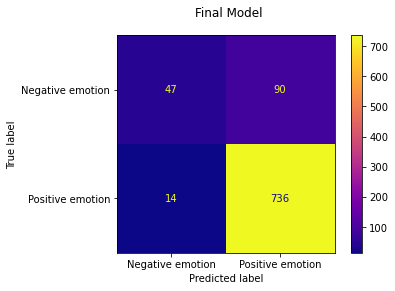

In [178]:
# creating confusion matrix for final model
fig, ax = plt.subplots()

fig.suptitle("Final Model")

plot_confusion_matrix(rf_final, test_vec, y_test, ax=ax, cmap="plasma");

# Visuals

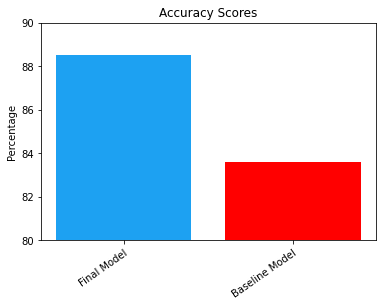

In [206]:
x_acc = ['Final Model', 'Baseline Model']
y_acc = [88.501,83.577]
plt.bar(x = x_acc, height = y_acc, color=['#1DA1F2', 'red'])
plt.xticks(rotation=35, ha="right", rotation_mode='anchor')
plt.ylim([80, 90])
plt.ylabel('Percentage')
plt.gca().yaxis.set_major_formatter(plt.matplotlib.ticker.StrMethodFormatter('{x:,.0f}'))
plt.title("Accuracy Scores")
plt.savefig('./accurancy_score.png', bbox_inches='tight');

We found out that the accuracy score is 83.577 for the baseline model. The best score for final model is 88.500 which was not a big improvement from the original data but it’s a pretty solid number closed to 90%.

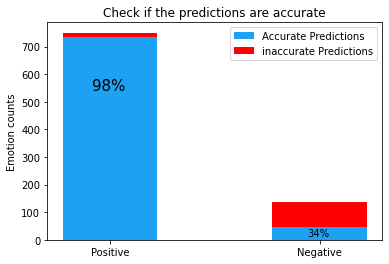

<Figure size 432x288 with 0 Axes>

In [207]:
labels = ['Positive', 'Negative']
co = [ 736, 47]
not_co = [14, 90]
width = 0.45

fig, ax = plt.subplots()

ax.bar(labels, co, width, label='Accurate Predictions', color='#1DA1F2')
ax.bar(labels, not_co, width, bottom=co,
       label='inaccurate Predictions', color='red')

ax.annotate('98%',xy=(45, 150), xycoords='axes pixels', fontsize=15)
ax.annotate('34%',xy=(260, 4), xycoords='axes pixels', fontsize=10)

ax.set_ylabel('Emotion counts')
ax.set_title('Check if the predictions are accurate')
ax.legend()



plt.show();
plt.savefig('./predictions.png', bbox_inches='tight');

The accurate prediction for positive emotion was great, but the model didn’t have a good performance with the negative emotion. The size of the dataset was one big reason for this. There are over 9000 rows for the original dataset but after we drop nans and filter row with only positive and negative emotions, only 3000 rows left. The model could have a better performance with more data points.

In [194]:
df['Product_Category'].value_counts()

Apple     5263
Google    2481
NAN       1348
Name: Product_Category, dtype: int64

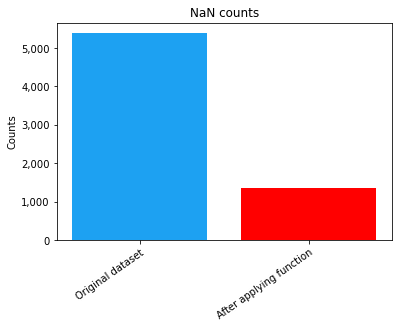

In [208]:
x_acc = ['Original dataset', 'After applying function']
y_acc = [5389,1348]
plt.bar(x = x_acc, height = y_acc, color=['#1DA1F2', 'red'])
plt.xticks(rotation=35, ha="right", rotation_mode='anchor')
plt.ylabel('Counts')
plt.gca().yaxis.set_major_formatter(plt.matplotlib.ticker.StrMethodFormatter('{x:,.0f}'))
plt.title("NaN counts")
plt.savefig('./check_nan.png', bbox_inches='tight');

# Limitation and future plan

For the limitation, the biggest limitation would be data point as I mentioned. Something about the original data was not that good so We create a function trying to find product category better and only have 1348 nans which is 4000 nans less compared with the original dataset. Another limitation would be the percentage of positive emotion is very high shown from the previous slides. So, in the future with more time and money, we want to add more datapoints and continue refining the model. Maybe trying multi class model with neutral emotion to make our model more powerful.

# Conclusion

In conclusion, our model had a solid performance about predicting the emotion from a tweet. By using our model, Apple marking department could instantly find out the thoughts from people about specific product like ipad or iphone. And then they can decide if are going to Increase production on products who with more positive emotion. Or maybe contact technical department to make improvement on products with more negative emotion.